# Content and Objective

+ Show estimation of psd w. MUSIC
+ Method: Get noise, filtered noise and sinusoid, and perform psd estimation

In [50]:
# importing
from typing import List, Union
import numpy as np
from numpy.random import default_rng
from numpy.typing import ArrayLike
from scipy import signal
from enum import Enum, auto

import matplotlib.pyplot as plt
from shutil import which

# showing figures inline
%matplotlib inline


In [51]:
# plotting options
plt.rcParams.update({
    "font.size": 36,
    "text.usetex": bool(which("latex")),
    "figure.figsize": (30, 8)
})


# Helper Functions

### Functions for estimating spectra 

In [52]:
def find_periodogram(y: ArrayLike, omega: ArrayLike) -> ArrayLike:
    """
    estimates the periodogram out from the observation at given frequencies

    :param y observation
    :param omega frequencies
    :return psd estimator
    """
    N = len(y)
    per = sum(y[p] * np.exp(-1j * omega * (p + 1)) for p in range(N))
    per = (abs(per)**2) / N

    return per


def est_acf(y: ArrayLike, est_type: str) -> ArrayLike:
    """
    estimates the discrete autocorrelation function (vector) given an array of observation

    :param y observation
    :param est_type "biased" or "unbiased"
    :return estimated acf, centered around 0
    """

    N = np.size(y)
    r = np.zeros_like(y)

    # loop lags of acf
    for k in np.arange(0, N):

        temp = np.sum(y[k:N] * np.conjugate(y[0:(N - k)]))

        # type of estimator
        if est_type == 'biased':
            r[k] = temp / N
        elif est_type == 'unbiased':
            r[k] = temp / (N - k)

    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])

    return np.append(r_reverse[0:len(r) - 1], r)

def find_music_estimate(y: ArrayLike, n: int, m: int,
                        omega: ArrayLike) -> ArrayLike:
    """
    estimates a pseudospectrum from the sampled signal at given frequencies using MUSIC
    
    :param y observation
    :param n order
    :param m size of observation 
    :param omega frequencies
    :return PSD estimate
    """

    N = len(y)
    per = np.zeros(len(omega), dtype=complex)

    # estimating the autocorrelation matrix
    R = np.zeros([m, m], dtype=complex)
    r = est_acf(y, 'biased')
    for p in np.arange(0, m):
        R[p, :] = r[N - 1 - p:N - 1 - p + m]

    per = np.zeros(len(omega), dtype=complex)

    # find eigendecomposition and assign noise space matrix G
    Lambda, X = np.linalg.eig(R)

    indices = Lambda.argsort()[0:m - n]
    G = X[:, indices]

    # find pseudospectrum
    # construcing matrix A, containing the vectors a(omega) for
    # samples in the frequency regime given by omega
    A = np.ones([m, len(omega)], dtype=complex)
    row_freq = np.exp(-1j * omega)
    for p in np.arange(1, m):
        A[p, :] = A[p - 1, :] * row_freq

    # matrix product
    GA = np.array(np.matrix(G).H * np.matrix(A))
    ps = np.sum(np.abs(GA)**2, axis=0)

    return 1.0 / ps


# Parameters

In [53]:
# number of samples and according time vector
N = int(1e2)

# noise variance
sigma2 = 3

# number of realizations for averaging
N_real = int(1e2)

# number of freq. points and freq. range
N_freq = 512
Ome = np.linspace(-np.pi, np.pi, N_freq)

# Number of sinusoids in line spectrum
n = 2

# apply if noise should be filtered
filtered = False
noise_filter_taps = None
# activate parameter "filtered" in parameters if you like to see filtered noise
if filtered:
    # filter parameters
    cutoff_freq = 1.0 / 4.0
    ripple_db = 60  # ripples and transition width of the filter
    width = 1 / 5.0
    N_filter, beta = signal.kaiserord(
        ripple_db, width)  # find filter order and beta parameter
    noise_filter_taps = signal.firwin(N_filter,
                                      cutoff=cutoff_freq,
                                      window=('kaiser', beta))

### Different signals to be used

In [54]:
class SignalType(Enum):
    """
    Class for setting the noise type
    """
    WHITE_NOISE = 1
    AR_SPECTRUM = auto()
    # filtered noise from Kroschel's publication (requires a frequency)
    AR_KROSCHEL = auto()
    # Wideband noise from Kroschel's publication (requires a frequency)
    WIDEBAND_NOISE_KROSCHEL = auto()
    DUAL_SINES = auto()
    DUAL_SINUSOIDS = auto()
    MULTI_SINUSOIDS = auto()


def get_signal(signal_type: SignalType,
               N: int,
               sigma2: float,
               noise_filter_taps: Union[None, ArrayLike] = None,
               rng: Union[None, np.random.Generator] = default_rng(),
               type_specific_arguments=None) -> np.ndarray:
    '''
    Generate different kinds of noisy signals
    
    :param signal_type type of signal. See SignalType.
    :param N length of signal
    :sigma2 noise variance
    :noise_filter_taps for white noise, specify None (default). For filtered noise, specify filter taps.
    :rng the random number generator. Leave at default for true random values
    :type_specific_arguments Some generators require further parameters
    '''
    # make noise
    if rng is None:
        # make it reproducible; if you want different noise each run, pass
        # rng = default_rng() to the get_signal call
        rng = default_rng(42)
    noise = np.random.normal(scale=sigma2**0.5, size=N)
    N_vec = np.arange(0, N)

    # if noise filter taps were passed, use them to shape the noise
    if noise_filter_taps:
        noise = signal.lfilter(noise_filter_taps, 1.0, noise)
        noise /= np.linalg.norm(noise)

    ST = SignalType
    # different types of signal
    generators = {
        ST.WHITE_NOISE:
        lambda _: noise,
        ST.AR_SPECTRUM:
        lambda _: signal.lfilter(
            b=[1], a=[1, -2.2137, 2.9403, -2.1697, 0.9606], x=noise),
        ST.AR_KROSCHEL:
        lambda freq: signal.lfilter(b=[1],
                                    a=[1 - 1.372, 1.843, -1.238, .849],
                                    x=noise),
        ST.WIDEBAND_NOISE_KROSCHEL:
        lambda freq: signal.lfilter(b=[1, 0, 0, 0, -.5],
                                    a=[1],
                                    x=noise),
        ST.DUAL_SINES:
        lambda _: noise + 
            sum(
            #np.sin(freq * np.arange(0, N)) for freq in {1.0}),
            np.sin(freq * np.arange(0, N)) for freq in {1.0, 1.2}),
            #np.sin(freq * np.arange(0, N)) for freq in {0.5,1.0,1.5,2.0}),
        ST.DUAL_SINUSOIDS:
        lambda _: sum(
            np.exp(1j * freq * np.arange(0, N))
            for freq in {1.0, 1.2}) + noise,
        ST.MULTI_SINUSOIDS:
        lambda freqs_ampls: sum(ampl * np.exp(1j * freq * np.arange(0, N))
                                for freq, ampl in freqs_ampls.items()) + noise
    }
    return generators[signal_type](type_specific_arguments)


# Loop for realizations

In [55]:
# initialize arrays
psd_per = np.empty([N_real, N_freq])
psd_music = np.empty([N_real, N_freq])
psd_music_plus_one = np.empty([N_real, N_freq])
if n > 1:
    psd_music_minus_one = np.empty([N_real, N_freq])

# loop for realizations
for _k in range(N_real):
    
    #y = get_signal(SignalType.WHITE_NOISE,
    #                   N,
    #                   sigma2,
    #                   noise_filter_taps=noise_filter_taps)

    #y = get_signal(SignalType.AR_SPECTRUM,
    #                   N,
    #                   sigma2,
    #                   noise_filter_taps=noise_filter_taps)
    
    #y = get_signal(SignalType.AR_KROSCHEL,
    #                    N,
    #                   sigma2,
    #                   noise_filter_taps=noise_filter_taps)
    
    #y = get_signal(SignalType.WIDEBAND_NOISE_KROSCHEL,
    #                   N,
    #                   sigma2,
    #                   noise_filter_taps=noise_filter_taps)
    #generate signal
    #y = get_signal(SignalType.DUAL_SINES,
    #                N,
    #                sigma2,
    #                noise_filter_taps=noise_filter_taps)
    #generate signal
    y = get_signal(SignalType.DUAL_SINUSOIDS,
                    N,
                    sigma2,
                    noise_filter_taps=noise_filter_taps)
    #alternatively: make sinusoids that probably aren't too far apart in spectrum, and have narrowly distributed amplitude
    #gen = default_rng(n)
    #freq = gen.exponential(scale=np.pi / 3, size=n) % np.pi - np.pi / 2
    #ampl = gen.rayleigh(scale=1, size=n)
    #y = get_signal(
    #        SignalType.MULTI_SINUSOIDS,
    #        N,
    #        sigma2,
    #        noise_filter_taps=noise_filter_taps,
    #        type_specific_arguments={f: a for f, a in zip(freq, ampl)})

    # find estimations
    psd_per[_k, :] = find_periodogram(y, Ome)

    # MUSIC estimate (correct parameter)
    psd_music[_k, :] = find_music_estimate(y, n, N, Ome)
    # MUSIC estimate (estimate one more tone than there is)
    psd_music_plus_one[_k, :] = find_music_estimate(y, n + 1, N, Ome)
    # MUSIC estimate (estimate one lesstone than there is)
    if n > 1:
        psd_music_minus_one[_k, :] = find_music_estimate(y, n - 1, N, Ome)


# Plotting

<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:25: SyntaxWarning: invalid escape sequence '\P'
<>:25: SyntaxWarning: invalid escape sequence '\O'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:25: SyntaxWarning: invalid escape sequence '\P'
<>:25: SyntaxWarning: invalid escape sequence '\O'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_15327/730032758.py:5: SyntaxWarning: invalid escape sequence '\O'
  xlabel="$\Omega$",
/tmp/ipykernel_15327/730032758.py:6: SyntaxWarning: invalid escape sequence '\O'
  yla

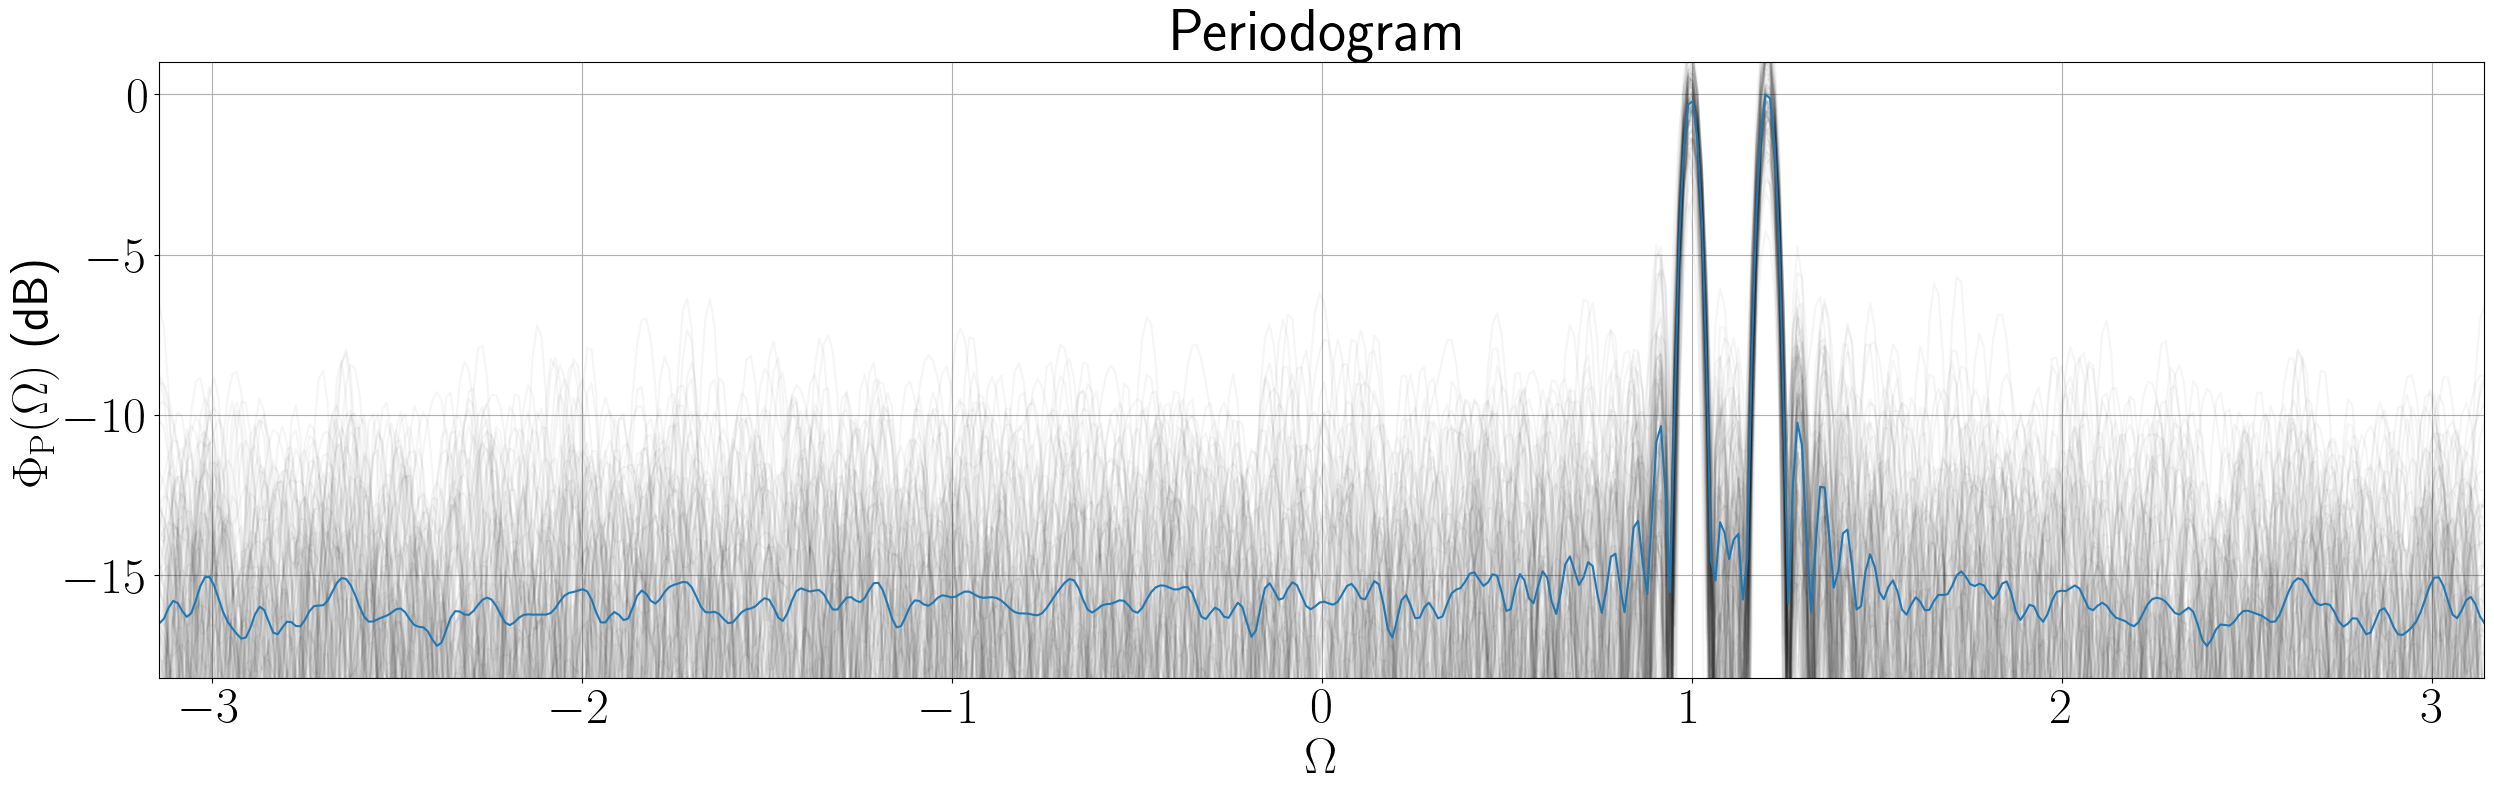

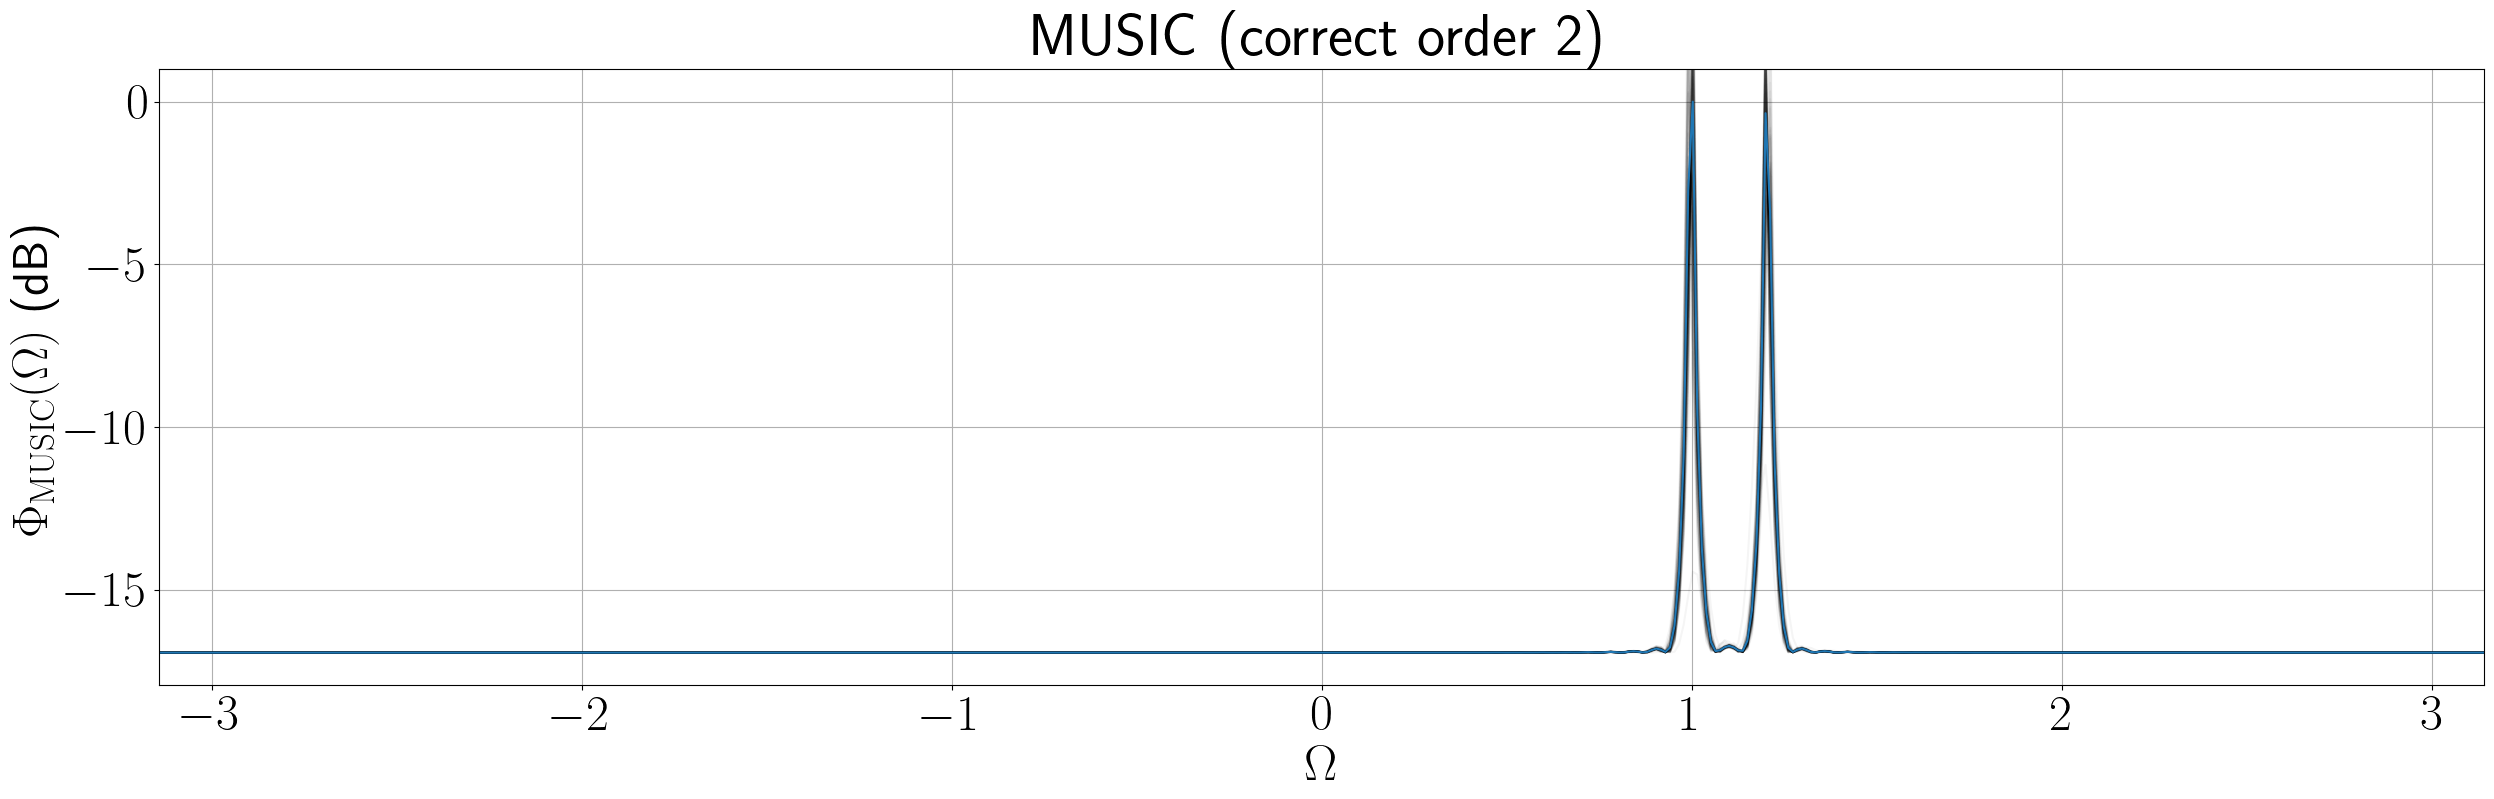

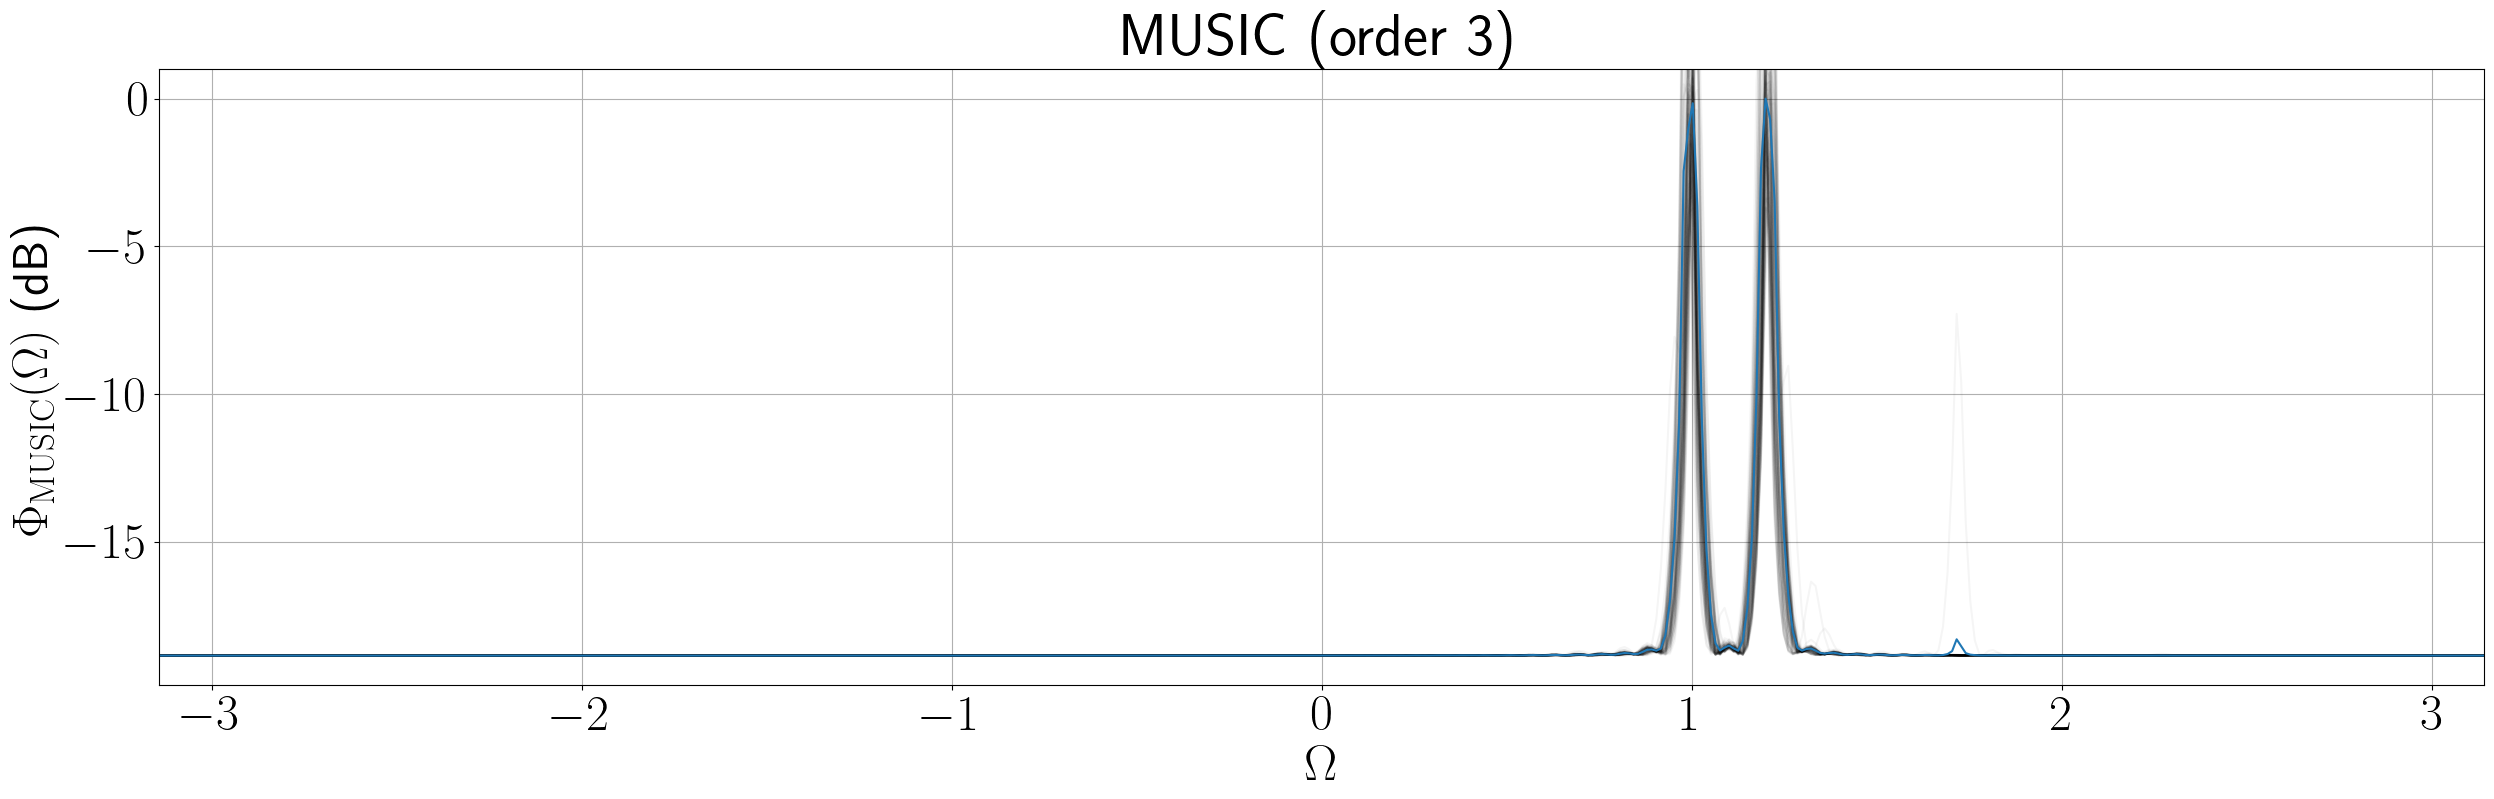

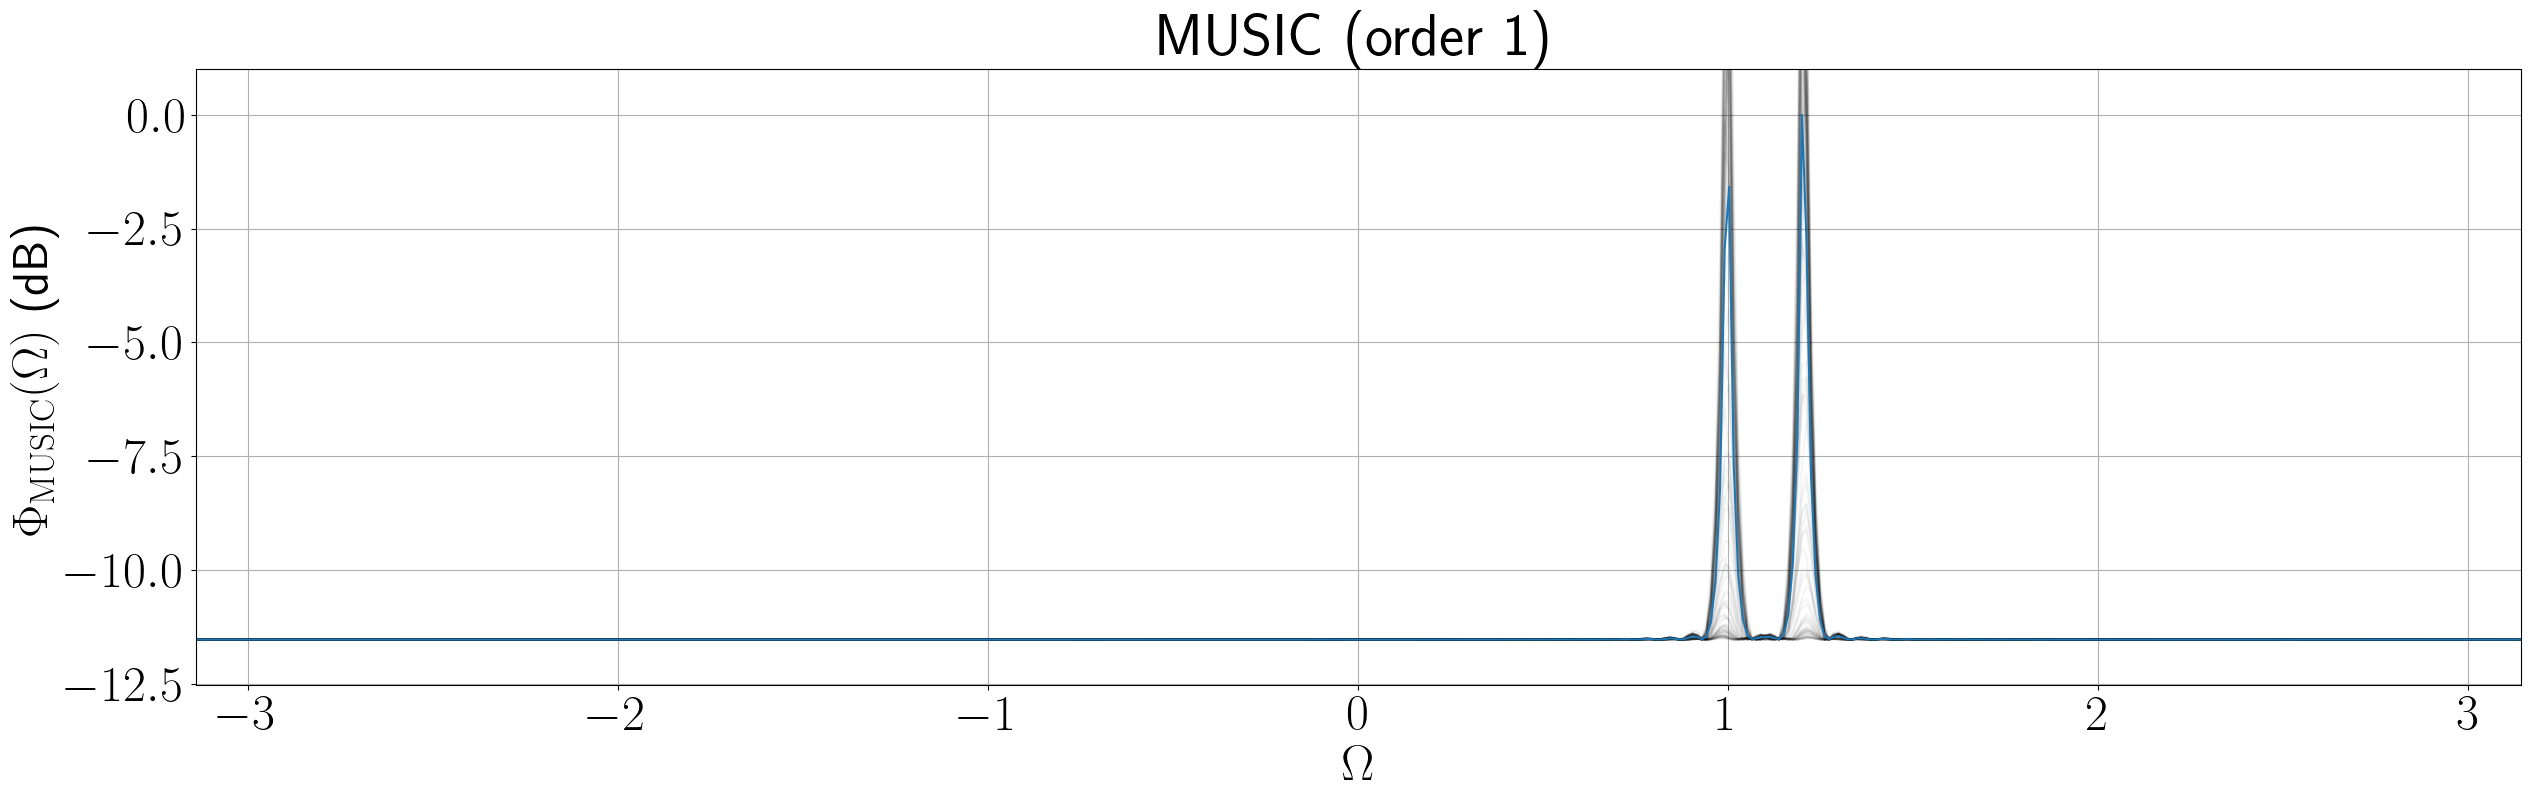

In [56]:
# plot psds
def plot(psd_realizations: List[ArrayLike],
         frequencies: ArrayLike,
         title="PSD estimate",
         xlabel="$\Omega$",
         ylabel="\Omega",
         ownfigure=True):
    if ownfigure:
        plt.figure()
    # averaging and finding variance
    psd_average = psd_realizations.mean(axis=0)
    max_average_db = 10 * np.log10(np.max(psd_average))
    min_average_db = 10 * np.log10(np.min(psd_average))

    for estimator_realization in psd_realizations:
        plt.plot(frequencies,
                 10 * np.log10(estimator_realization) - max_average_db,
                 color="black",
                 alpha=4.0 / N_real)
    plt.plot(frequencies, 10 * np.log10(psd_average) - max_average_db)
    plt.grid(True)
    plt.title(title)
    plt.axis([-np.pi, np.pi, min_average_db - max_average_db - 1, 1])
    plt.xlabel(xlabel)
    plt.ylabel(f"$\Phi_{ylabel}(\Omega)$ (dB)")


plot(psd_per, Ome, "Periodogram", ylabel="\mathrm{P}")
plot(psd_music, Ome, f"MUSIC (correct order {n})", ylabel="\mathrm{MUSIC}")
plot(psd_music_plus_one, Ome, f"MUSIC (order {n+1})", ylabel="\mathrm{MUSIC}")
if n > 1:
    plot(psd_music_minus_one,
         Ome,
         f"MUSIC (order {n-1})",
         ylabel="\mathrm{MUSIC}")